# Calculating Fisher Information and Smooth Components of the Correlation Function and Power Spectrum
### Sam Bellman

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from vega import VegaInterface, Wedge
import mcfit
from scipy import constants
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.misc import derivative
import copy
myplot_specs = { 
 'axes.linewidth':  1.5,  
 'xtick.top' : True,          
 'ytick.right' :  True, 
 'xtick.direction' : 'in',     
 'ytick.direction' : 'in',  
 'xtick.major.size' : 11,      
 'ytick.major.size' : 11, 
 'xtick.minor.size' : 5.5,     
 'ytick.minor.size' : 5.5,       
 'font.size' : 18,               
 'figure.figsize' : [22,11],  
 'lines.linewidth' : 1.5       
} 
 
# Update the plot style dictionary. 
plt.rcParams.update(myplot_specs) 

## Fetch Mock and initialize fiducial cosmology in a dictionary using vega

In [3]:
vega = VegaInterface("main-desi_auto.ini")

INFO: reading input Pk c:\users\samue\vega\vega\models\Planck18\Planck18_z_2.406.fits
Reading data file c:\users\samue\vega\vega\models\Planck18\Auto\cf_lya_lya_0_10-exp.fits.gz



In [4]:
fiducial = {}
    # Open the fits file and get what we need

hdul = fits.open('Planck18_z_2.406.fits')
fiducial['z_fiducial'] = hdul[1].header['ZREF']
fiducial['Omega_m'] = hdul[1].header['OM']
fiducial['Omega_de'] = hdul[1].header['OL']
fiducial['k'] = hdul[1].data['K']
fiducial['pk_full'] = hdul[1].data['PK']
fiducial['pk_smooth'] = hdul[1].data['PKSB']

hdul.close()

## Defining the necessary functions to calculate fisher matrices and smooth component of correlation function

In [5]:
def pk_to_xi(k, Pk, ell=0, extrap=True):
    xi = mcfit.P2xi(k, l=ell, lowring=True)
    rr, CF = xi(Pk, extrap=extrap)
    return InterpolatedUnivariateSpline(rr, CF)

def xi_to_pk(r, xi, ell=0, extrap=False):
    P = mcfit.xi2P(r, l=ell, lowring=True)
    kk, Pk = P(xi, extrap=extrap)
    return InterpolatedUnivariateSpline(kk, Pk)

def nth_orderpoly(r,*args):
    n = len(args)-3
    powers = np.arange(-3,n)
    model = np.zeros((len(args), r.size))
    tw = r != 0.
    for i,(par,power) in enumerate(zip(args,powers)):
        model[i, tw] = par * r[tw]**(power)
        model = np.array(model)
    return model.sum(axis=0)

def make_fit(n,sb1min,sb1max,sb2min,sb2max):
    '''
    Takes desired polynomial order and minimum and maximum values for sidebands of the correlation function in Mpc/h
    as inputs.
    Returns Fisher Information Matrices, Smooth component of Power Spectrum, and Smooth Component of Correlation Function.
        Final order of Polynomial fit will be n-1, with order beginning at -3
        Ex: inputing n = 3 with return a polynomial of lowest order -3, and highest order 2.
        
    Example input:
        Fisher, pkSB, xiSB = make_fit(2,50,86,150,190) will return fisher information matrices for all parameters in the 
        mock in the form of a dictionary, and smooth components of the power spectrum and correlation function using a 
        5th order polynomial for the fit with the first sideband from 50-86 Mpc/h and second sideband from 150-190 Mpc/h.
    '''
    Pl18 = (hdul[1].header['H0'] / 67.31) * (hdul[1].header['RDRAG'] / 147.334271564563)
    sb1_rmin = sb1min * Pl18
    sb1_rmax = sb1max * Pl18
    sb2_rmin = sb2min * Pl18
    sb2_rmax = sb2max * Pl18
    def make_pkSB(n):
        '''
        Generates smooth power spectrum and correlation function
        '''
        xi = pk_to_xi(fiducial['k'], fiducial['pk_full'])
        r = np.logspace(-4., 3.5, 5000)
        xi = xi(r)
        w = ((r >= sb1_rmin) & (r < sb1_rmax)) | ((r >= sb2_rmin) & (r < sb2_rmax))
        sigma = 0.1 * np.ones(xi.size)
        sigma[(r >= sb1_rmin - 2.) & (r < sb1_rmin + 2.)] = 1.e-6
        sigma[(r >= sb2_rmax - 2.) & (r < sb2_rmax + 2.)] = 1.e-6
        popt, pcov = curve_fit(nth_orderpoly, r[w], xi[w], p0=np.zeros(n+3),sigma=sigma[w])

        model = nth_orderpoly(r, *popt)
        xiSB = xi.copy()
        ww = (r >= sb1_rmin) & (r < sb2_rmax)
        xiSB[ww] = model[ww]
        pkSB = xi_to_pk(r, xiSB, extrap=True)
        pkSB = pkSB(fiducial['k'])
        pkSB *= fiducial['pk_full'][-1] / pkSB[-1]
        return pkSB,xiSB
    pkSB,xiSB = make_pkSB(n)
    params = vega.params
    def param_deriv(params,pkSB):
        '''
        Computes Derivative od model with respect to parameters
        '''
        vega.fiducial['pk_smooth'] = pkSB
        derivs = {}
        for par_name in params:
            def model_(par_value):
                pars = copy.deepcopy(vega.params)
                pars[par_name] = par_value
                return vega.compute_model(pars)['lyaxlya']
            derivs[par_name] = derivative(model_, params[par_name],dx = 1e-10)
        return derivs
    derivs = param_deriv(params,pkSB)
    def fish(derivs):
        '''
        input dictionary of parameter derivatives
        outputs fisher matrices for each parameter
        '''
        cov = vega.data['lyaxlya'].cov_mat # Covariance Matrix
        cov_inv = np.linalg.inv(cov) # Inverse Covariance Matrix
        fish = {}
        for par_name in derivs:
            fish[par_name] = np.multiply(derivs[par_name],cov_inv*derivs[par_name]) # Hadamard product
        return fish
    fish = fish(derivs)
    return fish,pkSB,xiSB

## Example Uses of the make_fit Function

Defining some necessary variables for plotting.

In [8]:
r = vega.corr_items['lyaxlya'].r_mu_grid[0].reshape(50,50)
xi = pk_to_xi(fiducial['k'], fiducial['pk_full'])
logr = np.logspace(-4., 3.5, 5000)
xi = xi(logr)

Calling make fit for the same inputs shown in the docstring.

In [7]:
fishes, pkSB,xiSB= make_fit(2,50,86,150,190) # 5th order polynomial with default sidebands

C:\Users\samue\AppData\Local\Temp\ipykernel_11788\2574446193.py:67: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivs[par_name] = derivative(model_, params[par_name],dx = 1e-10)
C:\Users\samue\AppData\Local\Temp\ipykernel_11788\2574446193.py:67: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivs[par_name] = derivative(model_, params[par_name],dx = 1e-10)


**Plotting Fisher Matrices**

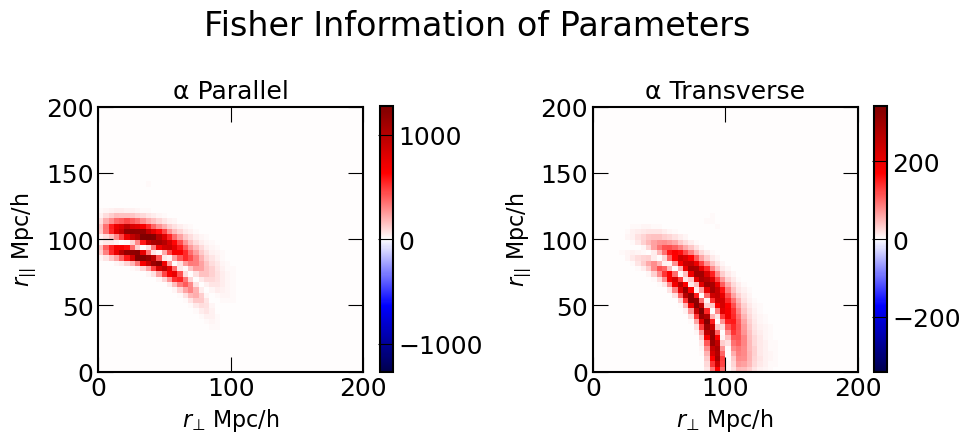

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,10))
# Setting up masking for small and large separation
fisher = copy.deepcopy(fishes['ap'].diagonal())
fisher[~vega.data['lyaxlya'].data_mask]=0
cap = np.max(np.abs(fisher))
# Plotting using imshow
ap = axs[0].imshow(fisher.reshape(50,50),vmin=-cap,vmax=cap,origin='lower',cmap='seismic',extent=[0,200,0,200])
# Colorbar is scaled to each parameter here.
axs[0].set_title('\u03B1 Parallel',fontsize=18)
axs[0].set_xlabel(r'$r_\bot$ Mpc/h',fontsize=16)
axs[0].set_ylabel(r'$r_{||}$ Mpc/h',fontsize=16)
fig.colorbar(ap,ax=axs[0],shrink=0.3)

fisher = copy.deepcopy(fishes['at'].diagonal())
fisher[~vega.data['lyaxlya'].data_mask]=0
cap = np.max(np.abs(fisher))
at = axs[1].imshow(fisher.reshape(50,50),vmin=-cap,vmax=cap,origin='lower',cmap='seismic',extent=[0,200,0,200])
axs[1].set_title('\u03B1 Transverse',fontsize=18)
axs[1].set_xlabel(r'$r_\bot$ Mpc/h',fontsize=16)
axs[1].set_ylabel(r'$r_{||}$ Mpc/h',fontsize=16)
fig.colorbar(at,ax=axs[1],shrink=0.3)

fig.suptitle('Fisher Information of Parameters ', fontsize=24,y=0.7)

plt.tight_layout()

**Plotting Correlation Functions**

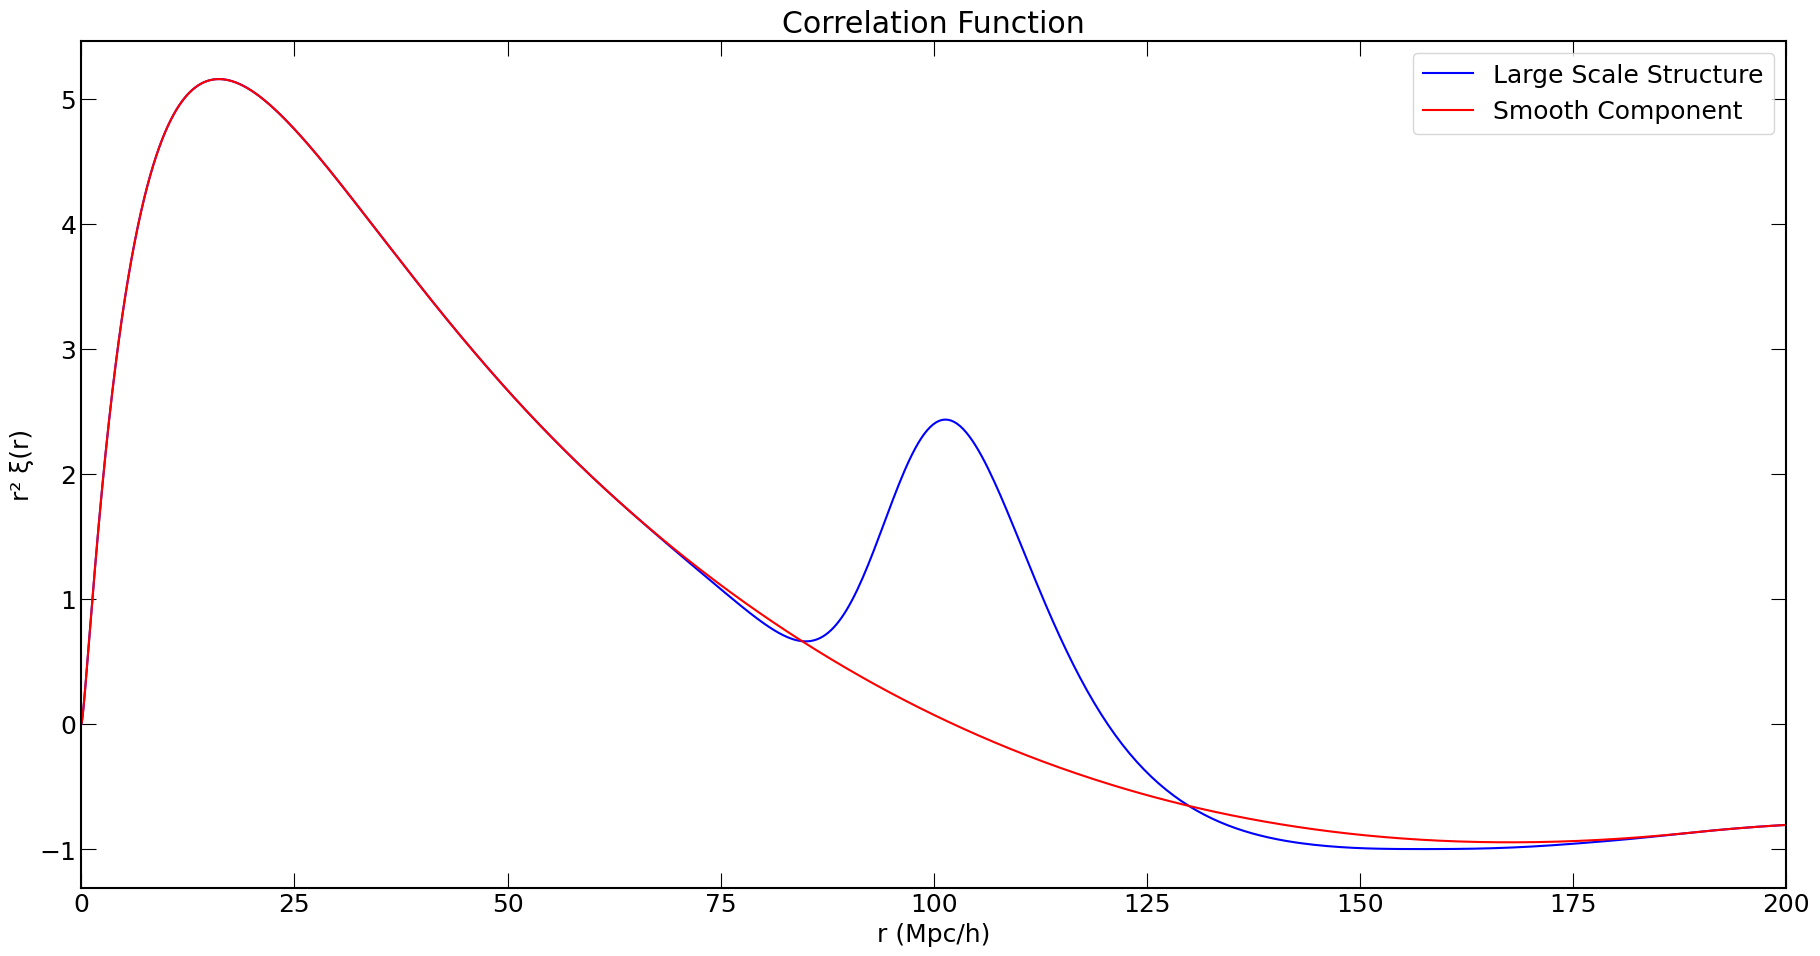

In [11]:
fig,axs=plt.subplots()
axs.set_title('Correlation Function')
# Correlation Functions are multiplied by separation squared to highlight features
axs.plot(logr,logr**2*xi,'-b',label='Large Scale Structure') # Fiducial Full Correlation
axs.plot(logr,logr**2*xiSB,'-r',label="Smooth Component") # Calculated Smooth Correlation
axs.set_xlim(0,200)
axs.legend(loc='upper right')
axs.set_xlabel('r (Mpc/h)')
axs.set_ylabel('r\u00b2 \u03BE(r)')
plt.show()

## Conclusions
This function can be quite powerful for computing fisher information for wide ranges of parameters and more complex mocks. It has been used in the past to calculate fisher information for various metal contaminants, fullshape parameters, etc. There are several known issues. First and foremost, the function utilizes scipy.misc.derivative, which has since been deprecated. Of the two alternatives suggested by scipy, numdifftools looks the most promising, though I was unable to implement this in the final function. It is important not to use sidebands that cut into the BAO peak, as this will provide terrible smooth fits. Using too high or too low a polynomial order will also worsen the fit.